In [21]:
# data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for better display of plots
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

try:
    cohort = pd.read_csv('cohort.csv')
    labs = pd.read_csv('lab_metrics_top50.csv')
    vitals = pd.read_csv('chart_metrics_top50.csv')
    treatments = pd.read_csv('treatments.csv')
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")

# dimensions
print(f"cohort dim: {cohort.shape}")
print(f"labs dim: {labs.shape}")
print(f"charts dim: {vitals.shape}")
print(f"treatments dim: {treatments.shape}")

Files loaded successfully.
cohort dim: (3876, 8)
labs dim: (137526, 5)
charts dim: (76955, 5)
treatments dim: (3876, 4)


In [25]:
def pivot_features(df, prefix):

    #pivots the dataframe from long to wide format and adds a prefix  to identify features.

    # we want one row for each patient and one colum for each variable
    # pivot table: index=HADM_ID, columns=feature_name, values=metrics
    df_pivot = df.pivot_table(
        index='HADM_ID',
        columns='feature_name',
        values=['mean_val', 'min_val', 'max_val']
    )

    df_pivot.columns = [f"{prefix}_{col[1]}_{col[0]}" for col in df_pivot.columns]

    return df_pivot

# pivot labs and vitals
labs_wide = pivot_features(labs, "Lab")
vitals_wide = pivot_features(vitals, "Vital")

# Merge everything into the main dataframe
master_df = pd.merge(cohort, treatments, on='HADM_ID', how='left')
master_df = pd.merge(master_df, labs_wide, on='HADM_ID', how='left')
master_df = pd.merge(master_df, vitals_wide, on='HADM_ID', how='left')

print(f"main dataframe shape: {master_df.shape}")

main dataframe shape: (3876, 335)


In [26]:
# standarization


# age correction (mimic sets >89 to 300)
# we cap 300 at 91.4
master_df.loc[master_df['age'] > 150, 'age'] = 91.4

# create a new variable 'is_male' (M/F -> 1/0)
if 'GENDER' in master_df.columns:
    master_df['is_male'] = master_df['GENDER'].map({'M': 1, 'F': 0})

# fahrenheit -> celsius
def convert_f_to_c(f_val):
    return (f_val - 32) * 5.0/9.0

master_df['Vital_Temp_Unified_max'] = np.nan
# take celsius if available
cols_c = [c for c in master_df.columns if 'Temperature' in c and ('C_' in c or 'Celsius' in c) and 'max' in c]
for c in cols_c:
    master_df['Vital_Temp_Unified_max'] = master_df['Vital_Temp_Unified_max'].fillna(master_df[c])

# fill gaps with converted fahrenheit
cols_f = [c for c in master_df.columns if 'Temperature' in c and ('F_' in c or 'Fahrenheit' in c) and 'max' in c]
for c in cols_f:
    master_df['Vital_Temp_Unified_max'] = master_df['Vital_Temp_Unified_max'].fillna(master_df[c].apply(convert_f_to_c))

Total Study Population: 3876
Survivors: 2545 (65.7%)
Non-Survivors: 1331 (34.3%)


,Total Cohort (Mean),Survivors (Mean),Non-Survivors (Mean)
age,67.285480,66.359572,69.055905
length_of_stay_days,15.114293,15.985462,13.448535
is_male,0.551084,0.546562,0.559730
vasopressor,0.721104,0.655796,0.845980
mechanical_ventilation,0.560630,0.474263,0.725770
rrt_dialysis,0.154799,0.121807,0.217881


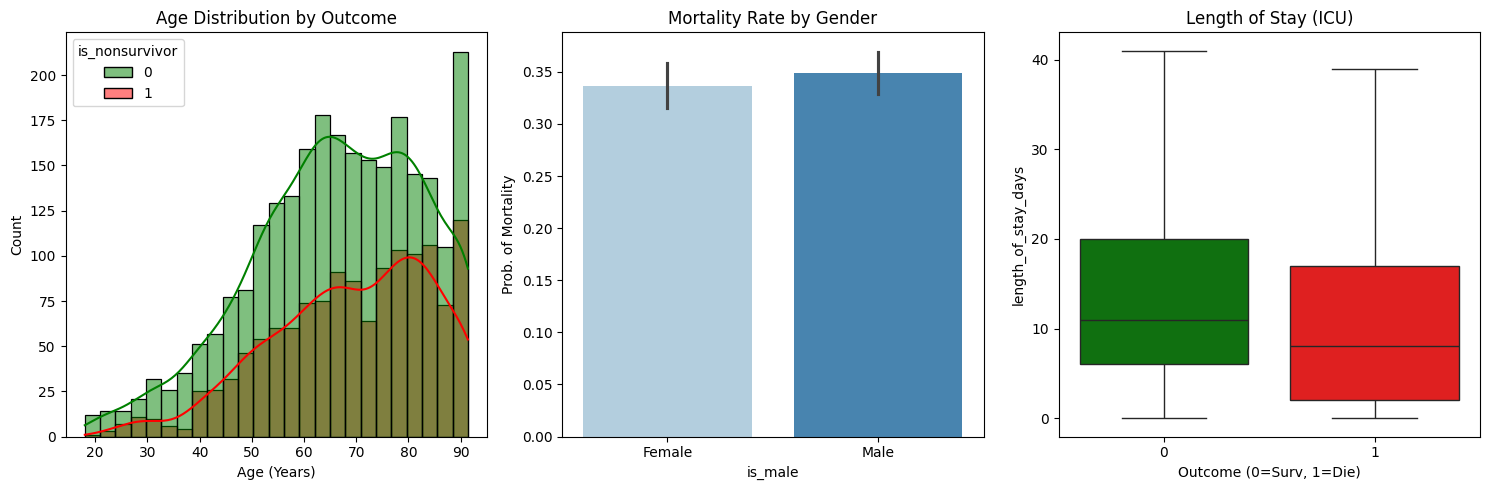

In [28]:
# descriptive analysis and demographics

# general overview
total_patients = len(master_df)
survivors = master_df[master_df['is_nonsurvivor'] == 0]
nonsurvivors = master_df[master_df['is_nonsurvivor'] == 1]

print(f"Total Study Population: {total_patients}")
print(f"Survivors: {len(survivors)} ({len(survivors)/total_patients:.1%})")
print(f"Non-Survivors: {len(nonsurvivors)} ({len(nonsurvivors)/total_patients:.1%})")

# we select demographic varaible and treatment variables (in order to know if they are already in septic shock)
demo_vars = ['age', 'length_of_stay_days', 'is_male',
             'vasopressor', 'mechanical_ventilation', 'rrt_dialysis']

table1 = master_df.groupby('is_nonsurvivor')[demo_vars].mean().transpose()
table1.columns = ['Survivors (Mean)', 'Non-Survivors (Mean)']

table1['Total Cohort (Mean)'] = master_df[demo_vars].mean()

table1 = table1[['Total Cohort (Mean)', 'Survivors (Mean)', 'Non-Survivors (Mean)']]

display(table1)

# plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# age distribution
plt.subplot(1, 3, 1)
sns.histplot(data=master_df, x='age', hue='is_nonsurvivor', kde=True, palette=['green', 'red'])
plt.title('Age Distribution by Outcome')
plt.xlabel('Age (Years)')

# mortality by gender
plt.subplot(1, 3, 2)
sns.barplot(x='is_male', y='is_nonsurvivor', data=master_df, palette='Blues')
plt.title('Mortality Rate by Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.ylabel('Prob. of Mortality')

# length of stay
plt.subplot(1, 3, 3)
sns.boxplot(x='is_nonsurvivor', y='length_of_stay_days', data=master_df, palette=['green', 'red'], showfliers=False)
plt.title('Length of Stay (ICU)')
plt.xlabel('Outcome (0=Surv, 1=Die)')

plt.tight_layout()
plt.show()

# EXPORT
master_df.to_csv('final_cohort_main_df.csv', index=False)
